In [2]:
#
# Testing non-polynomial types * exponential
#

[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]


/Users/woongkyujee/miniconda3/lib/python3.10/site-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 4125.140768
         Iterations: 221
         Function evaluations: 4081
         Gradient evaluations: 313
jac :  [ 6.55255127e+00  6.11877441e-01  8.93554688e-02  1.51977539e-02
 -1.24450684e-01 -4.03442383e-02 -4.88281250e-04 -1.77001953e-03
 -1.12426758e-01 -2.56347656e-02 -1.16333008e-01 -3.78417969e-02]
jac grad norm:  6.585128609498243
Estimated coefficients: [-5.03494672e-06  8.15836824e-02 -5.97755496e+00  4.24149070e+00
 -1.12451928e+00  1.93957272e+01 -2.17931504e+01 -2.96415697e+00
  1.35831558e+00  3.03012640e+00  1.50846232e+00  5.90615733e+00]
True coefficients: [0, -0.23, 4, -5, 0, -10, 6, 1, 1, 4.21, 6, 3.6]
diff : [ 5.03494672e-06 -3.11583682e-01  9.97755496e+00 -9.24149070e+00
  1.12451928e+00 -2.93957272e+01  2.77931504e+01  3.96415697e+00
 -3.58315577e-01  1.17987360e+00  4.49153768e+00 -2.30615733e+00]
norm : 3.5993958491691274
--------------------------------------------------------------------------------


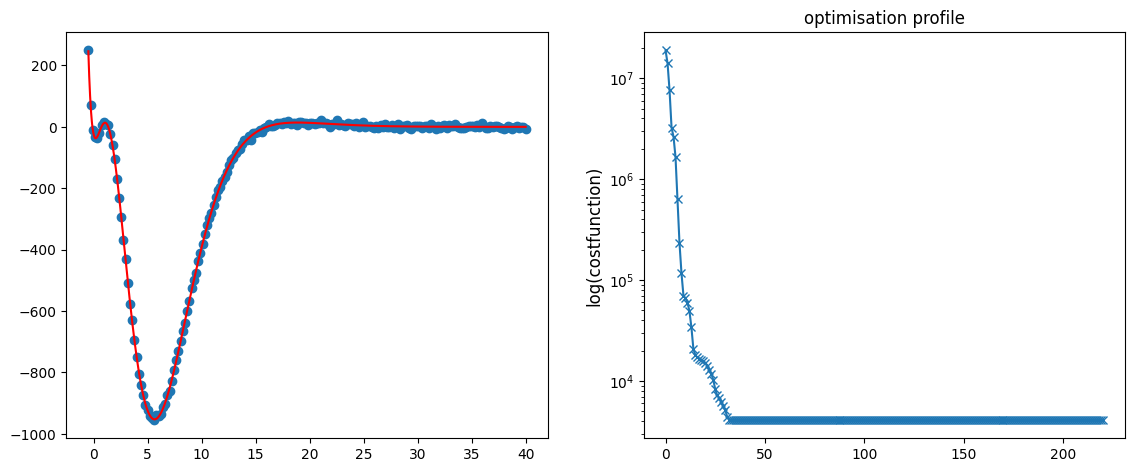

In [149]:
#
# Multiplication of two 3rd order polynomials - Applying Bounds
# 
import numpy as np
import scipy.optimize as opt
from matplotlib import pyplot as plt
import sys

dp_cnt = 200
rand_norm_std = 5
np.random.seed(42)
#
# Generate synthetic data from a known polynomial
# (1) f = a1 x^3 + b1 x^2 + c1 x + d1
# (2) g = a2 x^3 + b2 x^2 + d2 5x + d2
# (3) j = A * exp(-x/R)
# (4) k = B * exp(-x/S)
#
# Target
# h = f * g * j * k
#
# Generate dp_cnt points between x_min and x_max
#
x_min = -0.5
x_max = 40
noise_bool = True
x_data = np.linspace(x_min, x_max, dp_cnt) 
true_coeffs_1 = [2, -3, 4, -5] # True values of [a, b, c, d]
true_coeffs_2 = [0,-1,6,1]
true_coeffs_3 = [1,0.1315]
true_coeffs_4 = [0.01,0.245]

# working Example 1
true_coeffs_1 = [0, -0.23, 4, -5] # True values of [a, b, c, d]
true_coeffs_2 = [-10, 5, 6,1]     # 2nd and 3rd order likely to fail
true_coeffs_3 = [1,4.21]          # In case of, 1st-order poly * exponentials -> good to start with large rho values: not! less than 1
true_coeffs_4 = [6,3.6]           #

# working Example 2
true_coeffs_1 = [0, -0.23, 4, -5] # True values of [a, b, c, d]
true_coeffs_2 = [0, -10, 6,1]     # 2nd and 3rd order likely to fail
true_coeffs_3 = [1,4.21]          # In case of, 1st-order poly * exponentials -> good to start with large rho values: not! less than 1
true_coeffs_4 = [6,3.6]           #

A,R = true_coeffs_3
B,S = true_coeffs_4

true_coeffs = true_coeffs_1 + true_coeffs_2 + true_coeffs_3 + true_coeffs_4

f = np.polyval(true_coeffs_1, x_data) # np array
g = np.polyval(true_coeffs_2, x_data) # np array
j = A * np.exp(-x_data/R)             # np array
k = B * np.exp(-x_data/S)             # np array
if noise_bool == True:
    y_data = f * g * j * k + np.random.normal(0, rand_norm_std, size=len(x_data)) # Add noise
else:
    y_data = f * g * j * k

#
# Define the loss function to minimize
#
def loss(params, x, y):
    # x <array>
    # y <array>
    a1, b1, c1, d1, a2, b2, c2, d2, A, R, B, S = params # 12 parameters
    y_pred = (a1 * x**3 + b1 * x**2 + c1 * x + d1) * (a2 * x**3 + b2 * x**2 + c2 * x + d2) * ( A * np.exp(-x/R) ) * ( B * np.exp(-x/S) )
    return np.sum((y - y_pred) ** 2)  # Sum of squared errors (SSE)

optprofile = []
xkprofile = []
def record_optprofile(xk):
    optprofile.append(loss(xk,x_data,y_data))
    xkprofile.append(xk)
    
# Tolerance
xtol = 1e-6


# Initial guess for [a, b, c, d]
initial_guess_1 = [1, 1, 1, 1]
initial_guess_2 = [0,0,0,0]
initial_guess_3 = [1.,0.5]
initial_guess_4 = [1.,0.1]

initial_guess_1 = [0,0,-0.1,1]
initial_guess_2 = [1,1,1,1]
initial_guess_3 = [1.,4]             # In case of ... 
initial_guess_4 = [1.,5]             #
initial_guess = initial_guess_1 + initial_guess_2 + initial_guess_3  + initial_guess_4

#
# Applying Bounds
#
bounds = [ (0,0), (0,0), (None,None), (None,None), (0,0), (0,0), (None,None), (None,None), (None,None), (None,None) ]

bounds = [ (None,None) for i in range(len(initial_guess)) ] 
print(bounds)

# Minimize the loss function
_maxiter = 5000
bound_bool = False # default BFGS shows better performance

if bound_bool == True:
    result = opt.minimize(
        loss,
        initial_guess,
        args=(x_data, y_data),      # taking multiple inputs
        bounds = bounds,
        method='L-BFGS-B',
        tol = xtol,
        options={
            'disp':True,
            'maxiter': _maxiter,
            'gtol': 1e-8,
        },
        callback=record_optprofile, # record_optprofile <callable> optional
    )
else:
    result = opt.minimize(
        loss,
        initial_guess,
        args=(x_data, y_data),      # taking multiple inputs
        method='BFGS',
        tol = xtol,
        options={
            'disp':True,
            'maxiter': _maxiter,
            'gtol': 1e-8
        },
        callback=record_optprofile, # record_optprofile <callable> optional
    )


# Extract optimized coefficients
optimized_coeffs = result.x
if hasattr(result,'jac'):
    print("jac : ", result.jac)
    print("jac grad norm: ", np.linalg.norm(result.jac))
print("Estimated coefficients:", optimized_coeffs)
print("True coefficients:", true_coeffs)
diff = true_coeffs - optimized_coeffs
print(f'diff : {diff}')
print(f'norm : {np.linalg.norm(diff)/len(diff)}')
print('-'*80)

#
# profile by the fitted data
#
dp_cnt_val = dp_cnt * 10
x_val_data = np.linspace(x_min, x_max, dp_cnt_val)
y_val_f = np.polyval(optimized_coeffs[0:4],x_val_data)
y_val_g = np.polyval(optimized_coeffs[4:8],x_val_data)
y_val_j = optimized_coeffs[-4] * np.exp(-x_val_data / optimized_coeffs[-3])
y_val_k = optimized_coeffs[-2] * np.exp(-x_val_data / optimized_coeffs[-1])
y_val_data = y_val_f * y_val_g * y_val_j * y_val_k
#y_val_data = np.polyval(optimized_coeffs[0:4],x_val_data)*np.polyval(optimized_coeffs[4:8],x_val_data)


# --------------------------------------------------------
fig, ax = plt.subplots(1,2)
cm = 1/2.54
xl,yl = 32,12
fig.set_size_inches((xl*cm,yl*cm))
plt.subplots_adjust(
    left = 0.10,
    bottom = 0.1,
    right = 0.94,
    top = 0.96,
    wspace = 0.200,
    hspace = 0.0
)
fs, lfs = 12, 14 #fonts

ax[0].plot(x_data,y_data, marker='o',linestyle='')
# add by the fitted dataset
ax[0].plot(x_val_data,y_val_data,linestyle='-',color='r')


# opt profile
ax[1].plot(optprofile,marker='x',linestyle='-')
ax[1].set_yscale('log')
ax[1].set_title('optimisation profile')
ax[1].set_ylabel('log(costfunction)',fontsize=fs)

plt.show()

In [17]:
x = np.linspace(0,1,5)
print(x)
print(type(x))
#x = [ 1, 2, 3 ]

j = np.exp(-x)
print(j)

arr = []
for item in x:
    arr.append(np.exp(-item))
print(np.array(arr))

[0.   0.25 0.5  0.75 1.  ]
<class 'numpy.ndarray'>
[1.         0.77880078 0.60653066 0.47236655 0.36787944]
[1.         0.77880078 0.60653066 0.47236655 0.36787944]


[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
jac :  [-1.97141398e+02 -9.89982994e+00 -7.38492934e+00  4.22299136e+00
 -1.27628638e+02  5.09228073e+00 -2.92644986e+00  3.90623429e+00
  1.73560552e+01 -1.19308653e-01]
jac grad norm:  235.9558826688983
Estimated coefficients: [ 0.01134995  0.09451421 -4.33111856 -0.50146943 -0.00860965 -0.11914467
 -3.05418521  4.3999311   1.5343155   3.55464178]
True coefficients: [0, -0.23, 4, -5, 0, 0, 6, 1, 1, 5]
diff : [-1.13499539e-02 -3.24514208e-01  8.33111856e+00 -4.49853057e+00
  8.60965385e-03  1.19144666e-01  9.05418521e+00 -3.39993110e+00
 -5.34315501e-01  1.44535822e+00]
norm : 1.3626311910988844
--------------------------------------------------------------------------------


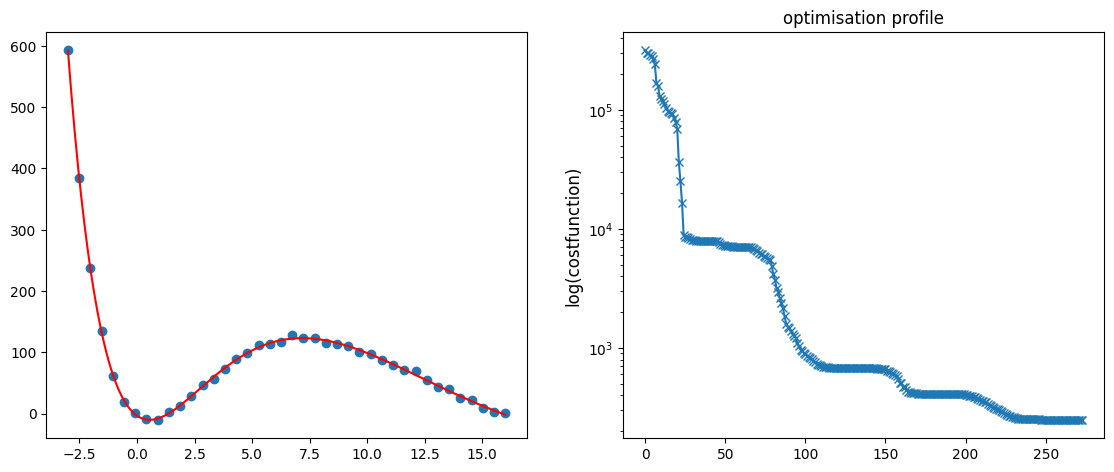

In [140]:
#
# Multiplication of two 3rd order polynomials - Applying Bounds
# 
import numpy as np
import scipy.optimize as opt
from matplotlib import pyplot as plt
import sys

dp_cnt = 40
rand_norm_std = 3
np.random.seed(42)
#
# Generate synthetic data from a known polynomial
# (1) f = a1 x^3 + b1 x^2 + c1 x + d1
# (2) g = a2 x^3 + b2 x^2 + d2 5x + d2
# (3) j = A * exp(-x/R)
#
# Target
# h = f * g * j
#
# Generate 50 points between -10 and 10
#
x_min = -3
x_max = 16
x_data = np.linspace(x_min, x_max, dp_cnt) 
true_coeffs_1 = [2, -3, 4, -5] # True values of [a, b, c, d]
true_coeffs_2 = [0,-1,6,1]
true_coeffs_3 = [1,0.1315]

true_coeffs_1 = [0, -0.23, 4, -5] # True values of [a, b, c, d]
true_coeffs_2 = [0, 0, 6,1]
true_coeffs_3 = [1,5]
A,R = true_coeffs_3

true_coeffs = true_coeffs_1 + true_coeffs_2 + true_coeffs_3

f = np.polyval(true_coeffs_1, x_data) # np array
g = np.polyval(true_coeffs_2, x_data) # np array
j = A * np.exp(-x_data /R)           # np array
y_data = f * g * j + np.random.normal(0, rand_norm_std, size=len(x_data)) # Add noise

#
# Define the loss function to minimize
#
def loss(params, x, y):
    # x <array>
    # y <array>
    a1, b1, c1, d1, a2, b2, c2, d2, A, R = params
    y_pred = (a1 * x**3 + b1 * x**2 + c1 * x + d1) * (a2 * x**3 + b2 * x**2 + c2 * x + d2) * ( A * np.exp(-x/R) )
    return np.sum((y - y_pred) ** 2)  # Sum of squared errors (SSE)

optprofile = []
xkprofile = []
def record_optprofile(xk):
    optprofile.append(loss(xk,x_data,y_data))
    xkprofile.append(xk)
    
# Tolerance
xtol = 1e-6


# Initial guess for [a, b, c, d]
initial_guess_1 = [1, 1, 1, 1]
initial_guess_2 = [0,0,0,0]
initial_guess_3 = [1.,0.5]

initial_guess_1 = [0,0,-0.1,1]
initial_guess_2 = [0,0,0.1,1]
initial_guess_3 = [1.,1]
initial_guess = initial_guess_1 + initial_guess_2 + initial_guess_3 

#
# Applying Bounds
#
bounds = [ (0,0), (0,0), (None,None), (None,None), (0,0), (0,0), (None,None), (None,None), (None,None), (None,None) ]

bounds = [ (None,None) for i in range(10) ] 
print(bounds)

# Minimize the loss function
_maxiter = 5000
bound_bool = True

if bound_bool == True:
    result = opt.minimize(
        loss,
        initial_guess,
        args=(x_data, y_data),      # taking multiple inputs
        bounds = bounds,
        method='L-BFGS-B',
        tol = xtol,
        options={
            'disp':True,
            'maxiter': _maxiter,
            'gtol': 1e-8,
        },
        callback=record_optprofile, # record_optprofile <callable> optional
    )
else:
    result = opt.minimize(
        loss,
        initial_guess,
        args=(x_data, y_data),      # taking multiple inputs
        method='BFGS',
        tol = xtol,
        options={
            'disp':True,
            'maxiter': _maxiter,
            'gtol': 1e-8
        },
        callback=record_optprofile, # record_optprofile <callable> optional
    )


# Extract optimized coefficients
optimized_coeffs = result.x
print("jac : ", result.jac)
print("jac grad norm: ", np.linalg.norm(result.jac))
print("Estimated coefficients:", optimized_coeffs)
print("True coefficients:", true_coeffs)
diff = true_coeffs - optimized_coeffs
print(f'diff : {diff}')
print(f'norm : {np.linalg.norm(diff)/len(diff)}')
print('-'*80)

#
# profile by the fitted data
#
dp_cnt_val = dp_cnt * 10
x_val_data = np.linspace(x_min, x_max, dp_cnt_val)
y_val_f = np.polyval(optimized_coeffs[0:4],x_val_data)
y_val_g = np.polyval(optimized_coeffs[4:8],x_val_data)
y_val_j = optimized_coeffs[-2] * np.exp(-x_val_data / optimized_coeffs[-1])
y_val_data = y_val_f * y_val_g * y_val_j
#y_val_data = np.polyval(optimized_coeffs[0:4],x_val_data)*np.polyval(optimized_coeffs[4:8],x_val_data)


# --------------------------------------------------------
fig, ax = plt.subplots(1,2)
cm = 1/2.54
xl,yl = 32,12
fig.set_size_inches((xl*cm,yl*cm))
plt.subplots_adjust(
    left = 0.10,
    bottom = 0.1,
    right = 0.94,
    top = 0.96,
    wspace = 0.200,
    hspace = 0.0
)
fs, lfs = 12, 14 #fonts

ax[0].plot(x_data,y_data, marker='o',linestyle='')
# add by the fitted dataset
ax[0].plot(x_val_data,y_val_data,linestyle='-',color='r')


# opt profile
ax[1].plot(optprofile,marker='x',linestyle='-')
ax[1].set_yscale('log')
ax[1].set_title('optimisation profile')
ax[1].set_ylabel('log(costfunction)',fontsize=fs)

plt.show()

[-0.33961078  2.06945256 -0.99422356 -0.00840288  1.68258817  1.13638405
  0.7559588  -0.15174725  1.15480783  0.3970389  -0.77308314  0.38600757
  0.77958336 -0.50826018  1.0089543   0.23513166 -0.3587986   4.13702618
  2.19844543 -0.59024688  3.04943727  0.69052398  0.36030425  0.46132494
  0.9157299   3.43968564 -1.01470079  0.29407916  2.27595801  1.05129825
 -1.19537705 -0.40128948  2.37376874]
Optimized Shared Parameters: [-0.33961078]
Optimized Dataset 1 Parameters: [ 2.06945256 -0.99422356 -0.00840288  1.68258817]
Optimized Dataset 2 Parameters: [ 1.13638405  0.7559588  -0.15174725  1.15480783]
Optimized Dataset 3 Parameters: [ 0.3970389  -0.77308314  0.38600757  0.77958336]
Optimized Dataset 4 Parameters: [-0.50826018  1.0089543   0.23513166 -0.3587986 ]
Optimized Dataset 5 Parameters: [ 4.13702618  2.19844543 -0.59024688  3.04943727]
Optimized Dataset 6 Parameters: [0.69052398 0.36030425 0.46132494 0.9157299 ]
Optimized Dataset 7 Parameters: [ 3.43968564 -1.01470079  0.294079

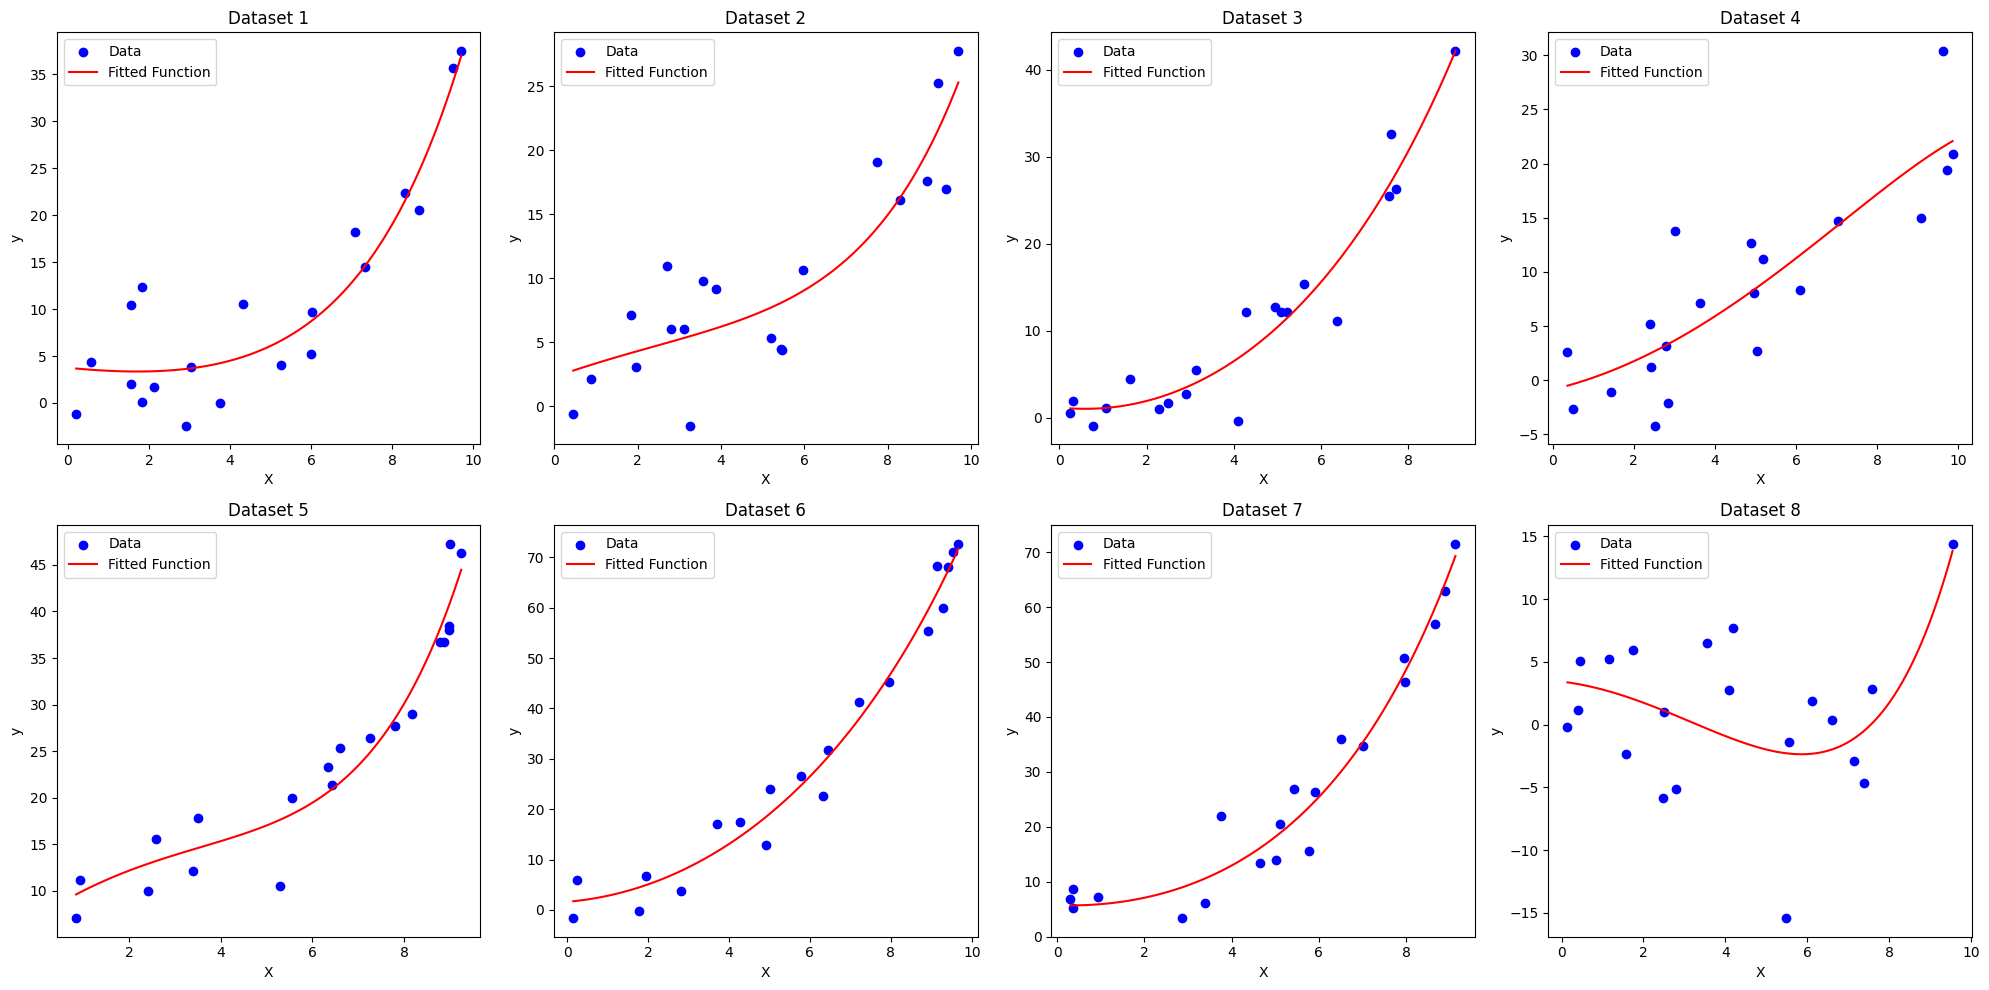

In [143]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the non-linear function: polynomial times exponential
def func(X, shared_params, dataset_params):
    # X is a matrix (n_samples x 1) with one input feature
    # shared_params: [exp_decay]
    # dataset_params: [const, linear, quadratic, exp_coeff]
    x = X[:, 0]  # Extract the single input feature
    return (
        dataset_params[0]  # Constant
        + dataset_params[1] * x  # Linear
        + dataset_params[2] * x**2  # Quadratic
        + dataset_params[3] * np.exp(-shared_params[0] * x)  # Exponential with shared decay
    )

# Define the global loss function for all datasets
def loss_function(params, datasets, num_datasets):
    shared_params = params[:1]  # First parameter is shared (exp_decay)
    dataset_params = params[1:].reshape(num_datasets, -1)  # Remaining are dataset-specific
    loss = 0
    for i, (X, y) in enumerate(datasets):
        predictions = func(X, shared_params, dataset_params[i])
        loss += np.sum((predictions - y) ** 2)  # Accumulate squared errors
    return loss

# Generate example data sets with some shared and some dataset-specific parameters
np.random.seed(42)
num_datasets = 8
datasets = []
shared_true_params = [0.3]  # Shared parameter: exp_decay
true_dataset_params = [
    [3.0, -1.5, 0.5, 2.0],  # Dataset 1
    [4.0, -1.0, 0.3, 1.5],  # Dataset 2
    [2.5, -2.0, 0.7, 2.2],  # Dataset 3
    [3.5, -1.8, 0.4, 2.8],  # Dataset 4
    [4.5, -1.2, 0.6, 1.9],  # Dataset 5
    [3.0, -0.8, 0.8, 2.5],  # Dataset 6
    [2.8, -1.3, 0.9, 2.1],  # Dataset 7
    [3.2, -1.6, 0.2, 1.8],  # Dataset 8
]

for params in true_dataset_params:
    X = np.random.rand(20, 1) * 10  # 20 samples, 1 feature
    noise = np.random.randn(20) * 5  # Add random noise
    y = func(X, shared_true_params, params) + noise
    datasets.append((X, y))

# Initial guess for parameters
# shared_params (1) + dataset_params (4 * num_datasets)
initial_params = np.array([0.5] + [1.0, 1.0, 1.0, 1.0] * num_datasets)

# Minimize the global loss function
result = minimize(
    loss_function,
    initial_params,
    args=(datasets, num_datasets),
    method="L-BFGS-B"
)
if hasattr(result,'x'):
    print(result.x)

# Extract optimized parameters
optimized_params = result.x
optimized_shared_params = optimized_params[:1]
optimized_dataset_params = optimized_params[1:].reshape(num_datasets, -1)

print("Optimized Shared Parameters:", optimized_shared_params)
for i, params in enumerate(optimized_dataset_params):
    print(f"Optimized Dataset {i+1} Parameters: {params}")

# Plotting the final fitting results for all datasets
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns of subplots

for i, (X, y) in enumerate(datasets):
    ax = axes[i // 4, i % 4]  # Get subplot index
    ax.scatter(X, y, label='Data', color='blue')  # Scatter plot of data points
    
    # Generate a smooth line for the fitted function
    x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)  # Continuous range for X
    y_line = func(x_line, optimized_shared_params, optimized_dataset_params[i])  # Fitted function values
    
    ax.plot(x_line, y_line, label='Fitted Function', color='red')  # Fitted line
    ax.set_title(f"Dataset {i+1}")
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("y")

plt.tight_layout()
plt.show()


6
--- working loss function
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 1300.5088892783401
        x: [ 3.152e-01  1.000e+00  4.849e-02  1.324e-03  8.003e+00
             9.999e+01  3.000e+01  5.000e+02]
      nit: 10
      jac: [-9.032e-01 -4.547e-05 -1.887e-03  2.282e+01  2.000e+01
            -2.842e-03  1.614e+01 -5.457e-04]
     nfev: 108
     njev: 12
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
[3.15228610e-01 9.99962329e-01 4.84879278e-02 1.32369120e-03
 8.00258431e+00 9.99943233e+01 3.00008395e+01 4.99998865e+02]
[[2.98e+02 1.00e-01 5.00e-01]
 [2.98e+02 4.00e-01 1.00e+00]
 [2.98e+02 3.00e-01 2.00e+00]
 [2.98e+02 2.00e-01 3.00e+00]
 [2.98e+02 8.00e-01 4.00e+00]
 [2.98e+02 1.00e+00 5.00e+00]]


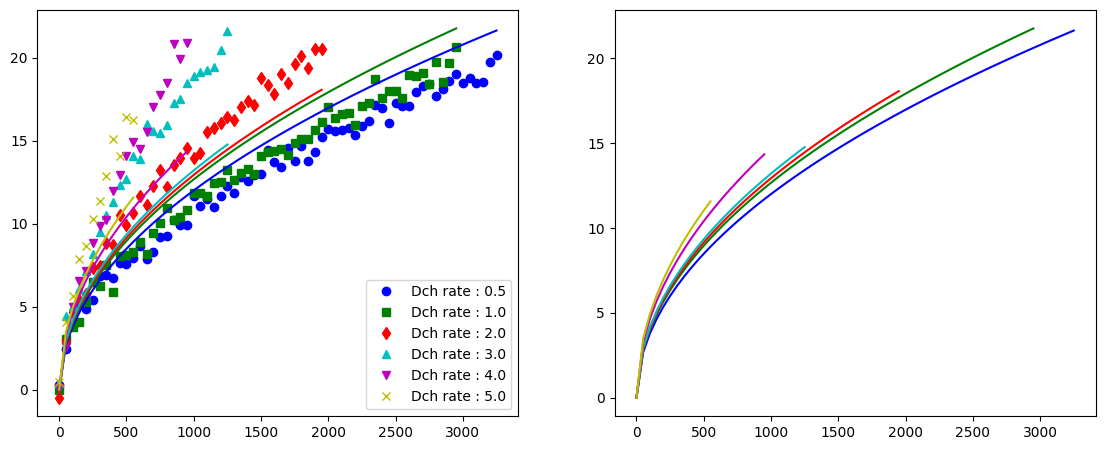

In [12]:
# a  # laset set Q gdegrows fastershow ffastest growtha  # laset set Q gdegrows fastershow ffastest growtha  # laset set Q gdegrows fastershow ffastest growtha  # laset set Q gdegrows fastershow ffastest growtha  # laset set Q gdegrows fastershow ffastest growtha  # laset set Q gdegrows fastershow ffastest growtha  # laset set Q gdegrows fastershow ffastest growtha  # laset set Q gdegrows fastershow ffastest growtha  # laset set Q gdegrows fastershow ffastest growth# # Data Loading
# https://pubs.rsc.org/en/content/articlelanding/2018/ra/c8ra04074e
#
# Q1(n) = C * n^z
# -----------------------------------------------------------------------------
#
import numpy as np
import scipy.optimize as opt
from matplotlib import pyplot as plt
import sys

exp_clist = np.array([0.37,0.36,0.46,0.39,0.27,0.32])
exp_zlist = np.array([0.49,0.50,0.50,0.56,0.63,0.63])

#
# later used for the model evaluation!
#
Templist  = np.array([ 298, 298, 298, 298, 298, 298 ])
Cratelist = np.array([ 0.2, 0.22, 0.33, 0.4, 0.4, 0.6 ])
Cratelist = np.array([ 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 ])
Dratelist = np.array([ 0.5, 1.0, 2.0, 3.0, 4.0, 5.0 ])

# data order                 0.5  1.0  2.0  3.0  4.0  5.0
exp_maxcyclelist = np.array([3300,3000,2000,1300,1000,600]) # last set Q show fastest growth
rand_normal_std = 0.5
np.random.seed(42)
#
# data creation
#
def ExpDataCreator(n,C,z):
    return C*np.power(n,z)
    
#np.random.normal(0, rand_norm_std, size=len(x_data))
#
# Generate loss data
#
_stride = 50
loss_data = [
    np.column_stack(
            (cycles := np.arange(0,maxcycle,_stride), ExpDataCreator(cycles,C,z) + np.random.normal(0,rand_normal_std,size=len(cycles)))
            )
        for C, z, maxcycle in zip(exp_clist, exp_zlist, exp_maxcyclelist)
    ]
# print(loss_data[0]) # shape size check
print(len(loss_data))

# --------------------------------------------------------
fig, ax = plt.subplots(1,2)
cm = 1/2.54
xl,yl = 32,12
fig.set_size_inches((xl*cm,yl*cm))
plt.subplots_adjust(
    left = 0.10,
    bottom = 0.1,
    right = 0.94,
    top = 0.96,
    wspace = 0.200,
    hspace = 0.0
)
fs, lfs = 12, 14 #fonts

markers = ['o', 's', 'd', '^', 'v', 'x']
colors  = ['b', 'g', 'r', 'c', 'm', 'y']

Dratelist = np.array([ 0.5, 1.0, 2.0, 3.0, 4.0, 5.0 ])

for k,Drate in enumerate(Dratelist):
    x_data = loss_data[k][:,0]
    y_data = loss_data[k][:,1]
    ax[0].plot(x_data,y_data,
            linestyle='',
            marker=markers[k],
            color=colors[k],
            label=f'Dch rate : {Drate}',
            )
    
ax[0].legend()
#plt.show()

# --------------------------------------------------------
# define Q components
#

# predefine constansts
_n = 0.5
_Ea = 10000
_R = 8.314
_T0 = 298.15
_T = 300

# T C D functions parameters
T1_initial_guess = [ 1, 1, 0.05 ] # h, DT, a : T0 = T0
C1_initial_guess = [ 0.5, 8 ] # AC, RhoC
D1_initial_guess = [ 100, 30 ] # AD, RhoD
B0_initial_guess = [ 1. ]
B0_initial_guess = [ 500. ]

#
# Note: missing items DOD, SOC info
#
def Q1Temp( params, Temp ): # expected length params : 3
    h, DT, a = params
    return h + DT * np.power( 1. - np.exp( a * (Temp - _T0) ), 2. )

def Q1ChCrate( params, Crate ): # expected length params : 2
    A, Rho = params
    return A * np.exp( Crate / Rho )

def Q1DchCrate( params, Crate ): # expected length params : 2
    A, Rho = params
    return A * np.exp( Crate / Rho )

def Q1loss( params , condition, cyc ):
    # params : component function parameters
    # cond   : experimental condition

    T_params = params[0:3]
    Ch_params = params[3:5]
    Dch_params = params[5:7]
    B0 = params[-1]

    Temp, ChCrate, DchCrate = condition
    
    return B0 * Q1Temp( T_params, Temp ) * Q1ChCrate( Ch_params, ChCrate ) * Q1DchCrate( Dch_params, DchCrate ) * np.exp(-_Ea / (Temp*_R)) * np.power(cyc,_n)
    
#
# Parameter Initiaul Guess : length 8
#
# h DT a / A Rho / A Rho / B0
initial_guess = T1_initial_guess + C1_initial_guess + D1_initial_guess + B0_initial_guess

# function testing condition - temporal later will be in a form of condition data <list or numpy array>
condition = [ _T, 0.5, 1.0 ] # temp ChCrate DchCrate
#Qcyc = Q1loss(initial_guess, condition, 21)
#print(Qcyc)

#
# DEFINE LOSS FUNCTION FOR THE DATA SET
#

# dummy data test
#dummy_data = np.column_stack(
#    (cycles := np.array([ i*30 for i in range(100) ]), Q1loss(initial_guess,condition,cycles))
#)
#dx_data = dummy_data[:,0]
#dy_data = dummy_data[:,1]
#ax[1].plot(dx_data,dy_data,)

#
# dataset : loss_data
#
print('--- working loss function')

def set_residual( params, data, condition ):
    '''
        data   : experimental data set
        params : model parameter
        conds  : data set sepcific parameters

        > data - condition (bound) : improve this by object coupling later * * *
    '''
    cycles = data[:,0] # 0 column -> cycles
    Qloss = data[:,1]  # 1 column -> Q loss for this data set
    rsd = Qloss - Q1loss(params, condition, cycles)
    #return rsd # rsd vector
    return np.linalg.norm(rsd)**2.

#rsd = set_residual( params, data, condition )
#print(rsd)

def objective_function( params, loss_data, condition_data ):

    rsd_sum = 0
    for data, condition in zip(loss_data,condition_data):
        rsd_sum += set_residual( params, data, condition )
        #
        # form of condition : e.g., Temp, ChCrate, DchCrate = cond
        #
    return rsd_sum

#
# need to construct condition data
#
Templist  = np.array([ 298, 298, 298, 298, 298, 298 ])
Cratelist = np.array([ 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 ])
Cratelist = np.array([ 0.1, 0.4, 0.3, 0.2, 0.8, 1.0 ])
Dratelist = np.array([ 0.5, 1.0, 2.0, 3.0, 4.0, 5.0 ])

condition_data = np.column_stack( (Templist,Cratelist,Dratelist) ) # or use vstack + transpose *.T


# ------- optimiser
xtol = 1e-6
_maxiter = 5000
optprofile = []
xkprofile = []
def record_optprofile(xk):
    optprofile.append(objective_function(xk,loss_data,condition_data))
    xkprofile.append(xk)

result = opt.minimize(
        objective_function,
        initial_guess,
        args=(loss_data, condition_data),      # taking multiple inputs
        method='L-BFGS-B',
        tol = xtol,
        options={
            'disp':True,
            'maxiter': _maxiter,
            'gtol': 1e-8
        },
        callback=record_optprofile, # record_optprofile <callable> optional
    )

print(result)
optimised_params = result.x
print(optimised_params)
print(condition_data)



#exp_maxcyclelist = [ 600 for i in range(6) ]

fit_result = [
    np.column_stack(
            (cycles := np.arange(0,maxcycle,_stride), Q1loss(optimised_params,condition,cycles))
    )
        for condition, maxcycle in zip(condition_data, exp_maxcyclelist)
    ]

for k,fit in enumerate(fit_result):
    dx_data = fit[:,0]
    dy_data = fit[:,1]
    ax[0].plot(dx_data,dy_data,color=colors[k])
    ax[1].plot(dx_data,dy_data,color=colors[k])
    

#for i in range(6):
#    for j in range(i+1,6):
#        resi = fit_result[i][:,1] - fit_result[j][:,1]
#        print(i,j,end='')
#        print(np.linalg.norm(resi))
plt.show()

In [175]:


# gpt example

import numpy as np
import scipy.optimize as opt

# Sub-function 1: Computes a transformation of x
def transformation(x):
    return np.sin(x) + x**2  # Example function

# Sub-function 2: Computes an additional term
def penalty(x):
    return 0.5 * (x - 2)**2  # A penalty term to influence optimization

# Loss function that combines other functions
def loss_function(x):
    return transformation(x) + penalty(x)  # Combines both functions

# Callback function to record the loss at each iteration
loss_history = []  # List to store loss values

def callback(xk):
    loss = loss_function(xk)
    loss_history.append(loss)  # Append the current loss to the list
    print(f"Current x: {xk}, Loss: {loss}")  # Optionally print the loss for each iteration

# Initial guess for x
x0 = np.array([0])

# Use scipy.optimize.minimize to find the optimal x with a callback
result = opt.minimize(loss_function, x0, callback=callback)

# Print results
print("Optimized x:", result.x)
print("Minimum loss:", result.fun)

# Print the loss history after optimization
print("\nLoss history for each iteration:", loss_history)

print(result)


Current x: [0.3550788], Loss: [1.82662808]
Current x: [0.35406776], Loss: [1.82662655]
Current x: [0.35400239], Loss: [1.82662655]
Optimized x: [0.35400239]
Minimum loss: 1.8266265451003783

Loss history for each iteration: [array([1.82662808]), array([1.82662655]), array([1.82662655])]
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.8266265451003783
        x: [ 3.540e-01]
      nit: 3
      jac: [-4.470e-08]
 hess_inv: [[ 3.770e-01]]
     nfev: 10
     njev: 5


Optimized Parameters: [0.1, 0.22500868289971498, 0.03441797488858188, 0.1, 39.43738261792415, 1.0, 100.0, 1000.0]


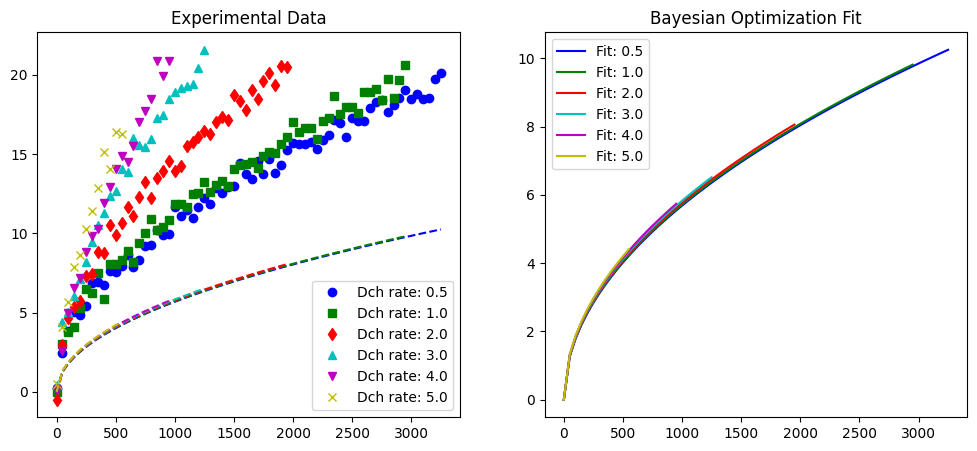

In [13]:
import numpy as np
import skopt
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
import matplotlib.pyplot as plt

# -------------------------
# Experimental Data (same as before)
# -------------------------
exp_clist = np.array([0.37, 0.36, 0.46, 0.39, 0.27, 0.32])
exp_zlist = np.array([0.49, 0.50, 0.50, 0.56, 0.63, 0.63])

Templist  = np.array([298] * 6)
Cratelist = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
Dratelist = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 5.0])

exp_maxcyclelist = np.array([3300, 3000, 2000, 1300, 1000, 600])
rand_normal_std = 0.5
np.random.seed(42)

def ExpDataCreator(n, C, z):
    return C * np.power(n, z)

# Generate loss data
_stride = 50
loss_data = [
    np.column_stack(
        (cycles := np.arange(0, maxcycle, _stride), 
         ExpDataCreator(cycles, C, z) + np.random.normal(0, rand_normal_std, size=len(cycles)))
    ) 
    for C, z, maxcycle in zip(exp_clist, exp_zlist, exp_maxcyclelist)
]

# -------------------------
# Model Definition
# -------------------------
_n = 0.5
_Ea = 10000
_R = 8.314
_T0 = 298.15

def Q1Temp(params, Temp):
    h, DT, a = params
    return h + DT * np.power(1. - np.exp(a * (Temp - _T0)), 2.)

def Q1ChCrate(params, Crate):
    A, Rho = params
    return A * np.exp( Crate / Rho)

def Q1DchCrate(params, Crate):
    A, Rho = params
    return A * np.exp( Crate / Rho )

def Q1loss(params, condition, cyc):
    T_params = params[0:3]
    Ch_params = params[3:5]
    Dch_params = params[5:7]
    B0 = params[-1]

    Temp, ChCrate, DchCrate = condition
    return B0 * Q1Temp(T_params, Temp) * Q1ChCrate(Ch_params, ChCrate) * Q1DchCrate(Dch_params, DchCrate) * np.exp(-_Ea / (Temp * _R)) * np.power(cyc, _n)

# -------------------------
# Define Optimization Functions
# -------------------------
condition_data = np.column_stack((Templist, Cratelist, Dratelist))

def set_residual(params, data, condition):
    cycles = data[:, 0]
    Qloss = data[:, 1]
    rsd = Qloss - Q1loss(params, condition, cycles)
    return np.linalg.norm(rsd)**2

def objective_function(params):
    return sum(set_residual(params, data, condition) for data, condition in zip(loss_data, condition_data))

# -------------------------
# Bayesian Optimization with Scikit-Optimize
# -------------------------
# Define search space for Bayesian Optimization
search_space = [
    Real(0.1, 5.0, name='h'),
    Real(0.01, 10.0, name='DT'),
    Real(0.001, 1.0, name='a'),
    Real(0.1, 10.0, name='AC'),
    Real(0.1, 100.0, name='RhoC'),
    Real(1.0, 100.0, name='AD'),
    Real(1.0, 100.0, name='RhoD'),
    Real(1000, 10000, name='B0')
]

# Define optimization function with named arguments
@use_named_args(search_space)
def bayesian_objective_function(**params):
    param_list = [params[name] for name in ['h', 'DT', 'a', 'AC', 'RhoC', 'AD', 'RhoD', 'B0']]
    return objective_function(param_list)

# Run Bayesian Optimization
result = gp_minimize(
    func=bayesian_objective_function,
    dimensions=search_space,
    n_calls=50,  # Number of iterations
    n_initial_points=20,  # Initial random samples
    acq_func="EI",  # Expected Improvement strategy
    random_state=42
)

# Optimized parameters
optimised_params = result.x
print("Optimized Parameters:", optimised_params)

# -------------------------
# Visualization of Fit
# -------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
markers = ['o', 's', 'd', '^', 'v', 'x']
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plot original data
for k, (Drate, data) in enumerate(zip(Dratelist, loss_data)):
    x_data, y_data = data[:, 0], data[:, 1]
    ax[0].plot(x_data, y_data, linestyle='', marker=markers[k], color=colors[k], label=f'Dch rate: {Drate}')

ax[0].legend()
ax[0].set_title("Experimental Data")

# Fit model with optimized parameters
fit_result = [
    np.column_stack(
        (cycles := np.arange(0, maxcycle, _stride), Q1loss(optimised_params, condition, cycles))
    ) 
    for condition, maxcycle in zip(condition_data, exp_maxcyclelist)
]

# Plot Bayesian Optimization Fit
for k, fit in enumerate(fit_result):
    dx_data, dy_data = fit[:, 0], fit[:, 1]
    ax[1].plot(dx_data, dy_data, linestyle='-', color=colors[k], label=f'Fit: {Dratelist[k]}')
    ax[0].plot(dx_data, dy_data, linestyle='--', color=colors[k])

ax[1].legend()
ax[1].set_title("Bayesian Optimization Fit")
plt.show()


Starting IRLS with dynamic weights:
Iteration 0:
  Params = [ 1.35479328e-01  1.11800513e-01 -5.78864940e-03  1.46475225e-03
  1.00021363e+01  2.39730722e+01  3.00011205e+01  4.99999987e+03]
  Weights = [0.20062384 0.00553536 0.09965564 0.00660132 0.02514271 0.08950738]
Iteration 1:
  Params = [1.35606872e-01 1.11660151e-01 7.43083808e-07 1.50916584e-03
 1.00021269e+01 2.39730723e+01 3.00011118e+01 4.99999987e+03]
  Weights = [1.19201632 0.00347241 2.10959367 0.00923293 0.03855003 0.13749544]
Iteration 2:
  Params = [1.35606900e-01 1.11660151e-01 7.43081418e-07 1.51168915e-03
 1.00021269e+01 2.39730723e+01 3.00011118e+01 4.99999987e+03]
  Weights = [1.03062606 0.0033891  2.65378616 0.00942154 0.03950107 0.14087103]
Iteration 3:
  Params = [1.35626181e-01 1.11660151e-01 2.36356648e-07 1.51237915e-03
 1.00021226e+01 2.39730724e+01 3.00011083e+01 4.99999987e+03]
  Weights = [0.96653747 0.00335995 2.83198006 0.00949057 0.03984659 0.14208276]
Iteration 4:
  Params = [1.35627389e-01 1.116601

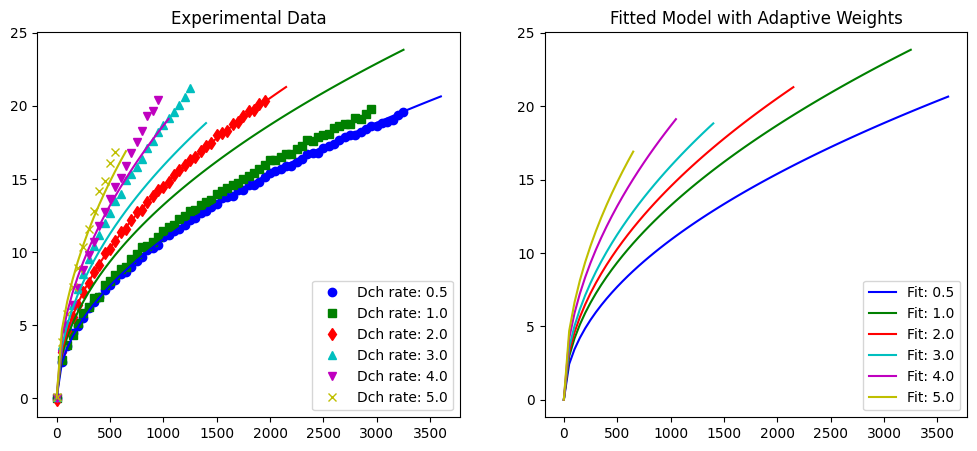

In [36]:
import numpy as np
import scipy.optimize as opt
from matplotlib import pyplot as plt

# -------------------------
# Data Loading and Generation
# -------------------------
exp_clist = np.array([0.37, 0.36, 0.46, 0.39, 0.27, 0.32])
exp_zlist = np.array([0.49, 0.50, 0.50, 0.56, 0.63, 0.63])

# Conditions used later for model evaluation
Templist  = np.array([280, 290, 295, 300, 305, 310])
Cratelist = np.array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
Cratelist = np.array([0.1, 0.4, 0.3, 0.2, 0.8, 1.0])
Dratelist = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 5.0])

# Maximum cycles for each dataset (order: dataset with fastest Q growth last)
exp_maxcyclelist = np.array([3300, 3000, 2000, 1300, 1000, 600])
rand_normal_std = 0.1
np.random.seed(42)

def ExpDataCreator(n, C, z):
    return C * np.power(n, z)

_stride = 50
loss_data = [
    np.column_stack(
        (cycles := np.arange(0, maxcycle, _stride), 
         ExpDataCreator(cycles, C, z) + np.random.normal(0, rand_normal_std, size=len(cycles)))
    )
    for C, z, maxcycle in zip(exp_clist, exp_zlist, exp_maxcyclelist)
]

# -------------------------
# Model Definition
# -------------------------
_n = 0.5
_Ea = 10000
_R = 8.314
_T0 = 298.15

def Q1Temp(params, Temp):
    """Temperature-dependent component.
       params: [h, DT, a]"""
    h, DT, a = params
    return h + DT * np.power(1. - np.exp(a * (Temp - _T0)), 2.)

def Q1ChCrate(params, Crate):
    """Charge rate component.
       params: [AC, RhoC]"""
    A, Rho = params
    return A * np.exp( Crate / Rho )

def Q1DchCrate(params, Crate):
    """Discharge rate component.
       params: [AD, RhoD]"""
    A, Rho = params
    return A * np.exp( Crate / Rho )

def Q1loss(params, condition, cyc):
    """
    Combined model output.
    params: [h, DT, a, AC, RhoC, AD, RhoD, B0]
    condition: [Temp, ChCrate, DchCrate]
    cyc: cycle number(s)
    """
    # Unpack parameters
    T_params = params[0:3]
    Ch_params = params[3:5]
    Dch_params = params[5:7]
    B0 = params[-1]

    Temp, ChCrate, DchCrate = condition
    return (B0 * Q1Temp(T_params, Temp) * Q1ChCrate(Ch_params, ChCrate) *
            Q1DchCrate(Dch_params, DchCrate) * np.exp(-_Ea / (Temp * _R)) *
            np.power(cyc, _n))

# -------------------------
# Initial Guess and Condition Data
# -------------------------
# Parameter initial guess: [h, DT, a, AC, RhoC, AD, RhoD, B0]
T1_initial_guess = [1, 0.2, 0.07]   # for Q1Temp
C1_initial_guess = [1, 10]         # for Q1ChCrate
D1_initial_guess = [24, 30]        # for Q1DchCrate
B0_initial_guess = [5000.]         # scale factor

initial_guess = T1_initial_guess + C1_initial_guess + D1_initial_guess + B0_initial_guess

# Construct condition data: each row corresponds to one dataset's [Temp, ChCrate, DchCrate]
condition_data = np.column_stack((Templist, Cratelist, Dratelist))

# -------------------------
# Weighted Loss Function and IRLS Implementation
# -------------------------
def weighted_objective(params, weights, loss_data, condition_data):
    """
    Computes the weighted sum of squared residuals over all datasets.
    weights: array of weights for each dataset.
    """
    total_loss = 0.0
    for i, (data, condition) in enumerate(zip(loss_data, condition_data)):
        cycles = data[:, 0]
        Qloss_data = data[:, 1]
        model_output = Q1loss(params, condition, cycles)
        residual = Qloss_data - model_output
        # Squared norm of the residual for this dataset
        res_norm2 = np.linalg.norm(residual)**2
        total_loss += weights[i] * res_norm2
    return total_loss

# IRLS parameters
max_irls_iter = 1000    # Maximum number of IRLS iterations
tol = 1e-6            # Convergence tolerance
epsilon = 1e-6        # Small constant to avoid division by zero

# Initialize weights equally for all datasets
weights = np.ones(len(loss_data))
weights = [1,1,1,1,1,1]
params = np.array(initial_guess)

print("Starting IRLS with dynamic weights:")
for it in range(max_irls_iter):
    # Optimize parameters given current weights using L-BFGS-B
    result = opt.minimize(weighted_objective, params, args=(weights, loss_data, condition_data),
                          method='L-BFGS-B', tol=tol)
    new_params = result.x

    # Update weights: here we use the inverse of the squared residual (plus epsilon)
    new_weights = []
    for data, condition in zip(loss_data, condition_data):
        cycles = data[:, 0]
        Qloss_data = data[:, 1]
        model_output = Q1loss(new_params, condition, cycles)
        residual = Qloss_data - model_output
        res_norm2 = np.linalg.norm(residual)**2
        new_weight = 1.0 / (res_norm2 + epsilon)
        new_weights.append(new_weight)
    new_weights = np.array(new_weights)

    print(f"Iteration {it}:")
    print("  Params =", new_params)
    print("  Weights =", new_weights)

    # Check for convergence (both parameters and weights)
    if np.linalg.norm(new_params - params) < tol and np.linalg.norm(new_weights - weights) < tol:
        params = new_params
        weights = new_weights
        break

    params = new_params
    weights = new_weights

print("\nOptimized Parameters after IRLS:", params)

# -------------------------
# Plotting the Results
# -------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
markers = ['o', 's', 'd', '^', 'v', 'x']
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plot original experimental data on the left
for k, (Drate, data) in enumerate(zip(Dratelist, loss_data)):
    x_data, y_data = data[:, 0], data[:, 1]
    ax[0].plot(x_data, y_data, linestyle='', marker=markers[k],
               color=colors[k], label=f'Dch rate: {Drate}')
ax[0].legend()
ax[0].set_title("Experimental Data")

# Generate and plot the fitted model curves on the left (on top of the ...) using the optimized parameters
fit_result = [
    np.column_stack(
        (cycles := np.arange(0, maxcycle + maxcycle*0.1, _stride),
         Q1loss(params, condition, cycles))
    )
    for condition, maxcycle in zip(condition_data, exp_maxcyclelist)
]

for k, fit in enumerate(fit_result):
    dx_data, dy_data = fit[:, 0], fit[:, 1]
    ax[0].plot(dx_data, dy_data, linestyle='-', color=colors[k],
               label=f'Fit: {Dratelist[k]}')
    ax[1].plot(dx_data, dy_data, linestyle='-', color=colors[k],
               label=f'Fit: {Dratelist[k]}')
ax[1].legend()
ax[1].set_title("Fitted Model with Adaptive Weights")

plt.show()


Starting IRLS with Basin Hopping for global optimization:
basinhopping step 0: f 1289.74
basinhopping step 1: f 1289.74 trial_f 1290.56 accepted 0  lowest_f 1289.74
basinhopping step 2: f 1289.74 trial_f 1298.82 accepted 0  lowest_f 1289.74
basinhopping step 3: f 1290.62 trial_f 1290.62 accepted 1  lowest_f 1289.74
basinhopping step 4: f 1290.62 trial_f 1289.18 accepted 0  lowest_f 1289.74
basinhopping step 5: f 1281.1 trial_f 1281.1 accepted 1  lowest_f 1281.1
found new global minimum on step 5 with function value 1281.1
basinhopping step 6: f 1276.21 trial_f 1276.21 accepted 1  lowest_f 1276.21
found new global minimum on step 6 with function value 1276.21
basinhopping step 7: f 1274.83 trial_f 1274.83 accepted 1  lowest_f 1274.83
found new global minimum on step 7 with function value 1274.83
basinhopping step 8: f 1274.83 trial_f 1277.13 accepted 0  lowest_f 1274.83
basinhopping step 9: f 1274.88 trial_f 1274.88 accepted 1  lowest_f 1274.83
basinhopping step 10: f 1264.66 trial_f 12

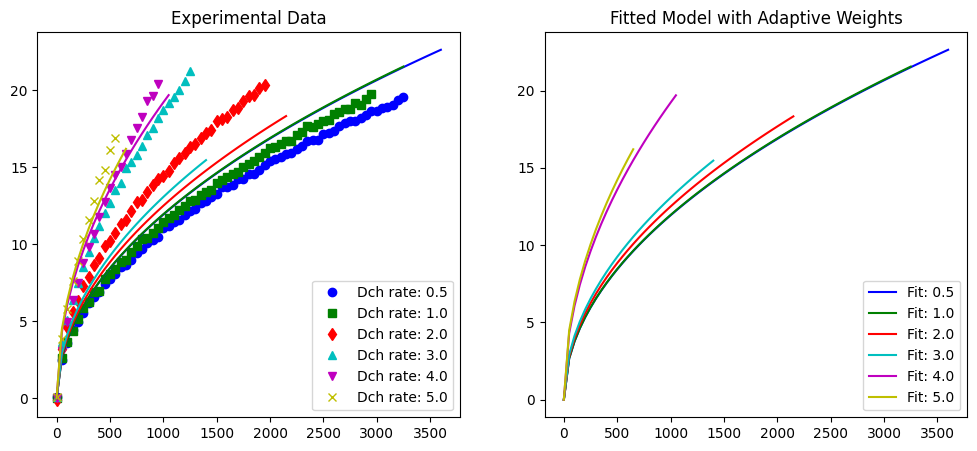

In [42]:
import numpy as np
import scipy.optimize as opt
from matplotlib import pyplot as plt

# -------------------------
# Data Loading and Generation
# -------------------------
exp_clist = np.array([0.37, 0.36, 0.46, 0.39, 0.27, 0.32])
exp_zlist = np.array([0.49, 0.50, 0.50, 0.56, 0.63, 0.63])

# Conditions used later for model evaluation
Templist  = np.array([280, 290, 295, 300, 308, 310])
Templist  = np.array([298, 298, 298, 298, 298, 298])
# Here we define two different Cratelists in your code; we'll use the second one:
Cratelist = np.array([0.53, 0.5, 0.5, 0.5, 1.0, 1.0])
Dratelist = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 5.0])

# Maximum cycles for each dataset (order: dataset with fastest Q growth last)
exp_maxcyclelist = np.array([3300, 3000, 2000, 1300, 1000, 600])
rand_normal_std = 0.1
np.random.seed(42)

def ExpDataCreator(n, C, z):
    return C * np.power(n, z)

_stride = 50
loss_data = [
    np.column_stack(
        (cycles := np.arange(0, maxcycle, _stride),
         ExpDataCreator(cycles, C, z) + np.random.normal(0, rand_normal_std, size=len(cycles)))
    )
    for C, z, maxcycle in zip(exp_clist, exp_zlist, exp_maxcyclelist)
]

# -------------------------
# Model Definition
# -------------------------
_n = 0.5
_Ea = 10000
_R = 8.314
_T0 = 298.15

def Q1Temp(params, Temp):
    """Temperature-dependent component.
       params: [h, DT, a]"""
    h, DT, a = params
    return h + DT * np.power(1. - np.exp(a * (Temp - _T0)), 2.)

def Q1ChCrate(params, Crate):
    """Charge rate component.
       params: [AC, RhoC]"""
    A, Rho = params
    return A * np.exp(Crate / Rho)

def Q1DchCrate(params, Crate):
    """Discharge rate component.
       params: [AD, RhoD]"""
    A, Rho = params
    return A * np.exp(Crate / Rho)

def Q1loss(params, condition, cyc):
    """
    Combined model output.
    params: [h, DT, a, AC, RhoC, AD, RhoD, B0]
    condition: [Temp, ChCrate, DchCrate]
    cyc: cycle number(s)
    """
    T_params = params[0:3]
    Ch_params = params[3:5]
    Dch_params = params[5:7]
    B0 = params[-1]

    Temp, ChCrate, DchCrate = condition
    return (B0 * Q1Temp(T_params, Temp) * Q1ChCrate(Ch_params, ChCrate) *
            Q1DchCrate(Dch_params, DchCrate) * np.exp(-_Ea / (Temp * _R)) *
            np.power(cyc, _n))

# -------------------------
# Initial Guess and Condition Data
# -------------------------
# Parameter initial guess: [h, DT, a, AC, RhoC, AD, RhoD, B0]
T1_initial_guess = [1, 0.2, 0.07]    # for Q1Temp
C1_initial_guess = [1, 10]           # for Q1ChCrate
D1_initial_guess = [24, 30]          # for Q1DchCrate
B0_initial_guess = [5000.]           # scale factor

initial_guess = T1_initial_guess + C1_initial_guess + D1_initial_guess + B0_initial_guess

# Construct condition data: each row corresponds to one dataset's [Temp, ChCrate, DchCrate]
condition_data = np.column_stack((Templist, Cratelist, Dratelist))

# -------------------------
# Weighted Loss Function and IRLS with Basin Hopping
# -------------------------
def weighted_objective(params, weights, loss_data, condition_data):
    """
    Computes the weighted sum of squared residuals over all datasets.
    weights: array of weights for each dataset.
    """
    total_loss = 0.0
    for i, (data, condition) in enumerate(zip(loss_data, condition_data)):
        cycles = data[:, 0]
        Qloss_data = data[:, 1]
        model_output = Q1loss(params, condition, cycles)
        residual = Qloss_data - model_output
        res_norm2 = np.linalg.norm(residual)**2
        total_loss += weights[i] * res_norm2
    return total_loss

# IRLS parameters
max_irls_iter = 2   # Maximum number of IRLS iterations
tol = 1e-6              # Convergence tolerance
epsilon = 1e-6          # Small constant to avoid division by zero

# Initialize weights equally for all datasets
weights = np.ones(len(loss_data))
params = np.array(initial_guess)

print("Starting IRLS with Basin Hopping for global optimization:")
for it in range(max_irls_iter):
    # Use basin hopping to try to reach a global minimum,
    # with L-BFGS-B as the local minimizer.
    minimizer_kwargs = {'method': 'L-BFGS-B', 'tol': tol, 'args': (weights, loss_data, condition_data)}
    result = opt.basinhopping(weighted_objective, params, minimizer_kwargs=minimizer_kwargs, niter=100, disp=True)
    new_params = result.x

    # Update weights: inverse of squared residual plus epsilon
    new_weights = []
    for data, condition in zip(loss_data, condition_data):
        cycles = data[:, 0]
        Qloss_data = data[:, 1]
        model_output = Q1loss(new_params, condition, cycles)
        residual = Qloss_data - model_output
        res_norm2 = np.linalg.norm(residual)**2
        new_weight = 1.0 / (res_norm2 + epsilon)
        new_weights.append(new_weight)
    new_weights = np.array(new_weights)

    print(f"Iteration {it}:")
    print("  Params =", new_params)
    print("  Weights =", new_weights)

    # Check for convergence (both parameters and weights)
    if np.linalg.norm(new_params - params) < tol and np.linalg.norm(new_weights - weights) < tol:
        params = new_params
        weights = new_weights
        break

    params = new_params
    weights = new_weights

print("\nOptimized Parameters after IRLS with Basin Hopping:", params)

# -------------------------
# Plotting the Results
# -------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
markers = ['o', 's', 'd', '^', 'v', 'x']
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plot original experimental data on the left
for k, (Drate, data) in enumerate(zip(Dratelist, loss_data)):
    x_data, y_data = data[:, 0], data[:, 1]
    ax[0].plot(x_data, y_data, linestyle='', marker=markers[k],
               color=colors[k], label=f'Dch rate: {Drate}')
ax[0].legend()
ax[0].set_title("Experimental Data")

# Generate and plot the fitted model curves using the optimized parameters
fit_result = [
    np.column_stack(
        (cycles := np.arange(0, maxcycle + int(maxcycle*0.1), _stride),
         Q1loss(params, condition, cycles))
    )
    for condition, maxcycle in zip(condition_data, exp_maxcyclelist)
]

for k, fit in enumerate(fit_result):
    dx_data, dy_data = fit[:, 0], fit[:, 1]
    ax[0].plot(dx_data, dy_data, linestyle='-', color=colors[k],
               label=f'Fit: {Dratelist[k]}')
    ax[1].plot(dx_data, dy_data, linestyle='-', color=colors[k],
               label=f'Fit: {Dratelist[k]}')
ax[1].legend()
ax[1].set_title("Fitted Model with Adaptive Weights")

plt.show()



basinhopping step 0: f 863.05
basinhopping step 1: f 863.05 trial_f 874.224 accepted 0  lowest_f 863.05
basinhopping step 2: f 864.124 trial_f 864.124 accepted 1  lowest_f 863.05
basinhopping step 3: f 864.124 trial_f 876.828 accepted 0  lowest_f 863.05
basinhopping step 4: f 859.395 trial_f 859.395 accepted 1  lowest_f 859.395
found new global minimum on step 4 with function value 859.395
basinhopping step 5: f 857.547 trial_f 857.547 accepted 1  lowest_f 857.547
found new global minimum on step 5 with function value 857.547
basinhopping step 6: f 857.547 trial_f 865.576 accepted 0  lowest_f 857.547
basinhopping step 7: f 857.547 trial_f 859.65 accepted 0  lowest_f 857.547
basinhopping step 8: f 856.816 trial_f 856.816 accepted 1  lowest_f 856.816
found new global minimum on step 8 with function value 856.816
basinhopping step 9: f 849.785 trial_f 849.785 accepted 1  lowest_f 849.785
found new global minimum on step 9 with function value 849.785
basinhopping step 10: f 847.009 trial_f

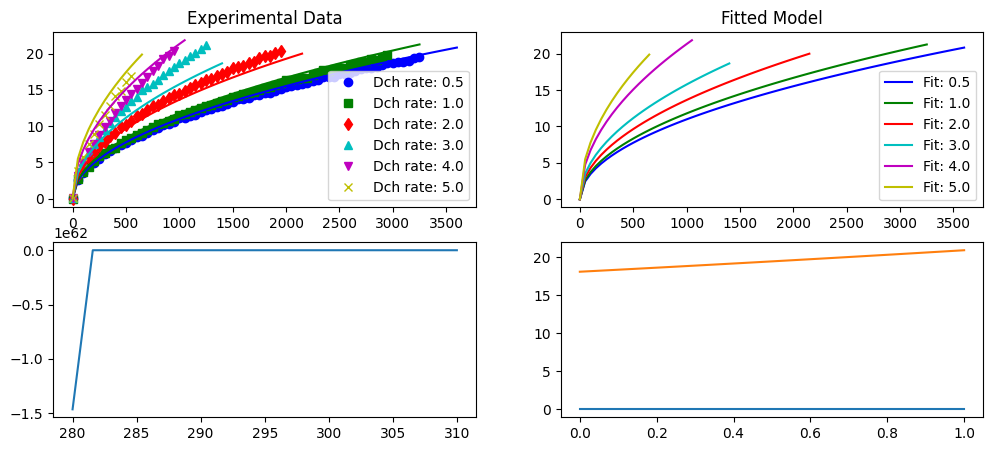

In [59]:
import numpy as np
import scipy.optimize as opt
from matplotlib import pyplot as plt

# -------------------------
# Data Loading and Generation
# -------------------------
exp_clist = np.array([0.37, 0.36, 0.46, 0.39, 0.27, 0.32])
exp_zlist = np.array([0.49, 0.50, 0.50, 0.56, 0.63, 0.63])

# Conditions used later for model evaluation
Templist  = np.array([298, 298, 298, 298, 298, 298])
Cratelist = np.array([0.53, 0.5, 0.5, 0.5, 5.0, 5.0])
Dratelist = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 5.0])

# Maximum cycles for each dataset (order: dataset with fastest Q growth last)
exp_maxcyclelist = np.array([3300, 3000, 2000, 1300, 1000, 600])
rand_normal_std = 0.1
np.random.seed(42)

def ExpDataCreator(n, C, z):
    return C * np.power(n, z)

_stride = 50
loss_data = [
    np.column_stack(
        (cycles := np.arange(0, maxcycle, _stride),
         ExpDataCreator(cycles, C, z) + np.random.normal(0, rand_normal_std, size=len(cycles)))
    )
    for C, z, maxcycle in zip(exp_clist, exp_zlist, exp_maxcyclelist)
]

# -------------------------
# Model Definition
# -------------------------
_n = 0.5
_Ea = 10000
_R = 8.314
_T0 = 298.15

def Q1Temp(params, Temp):
    """Temperature-dependent component.
       params: [h, DT, a]"""
    h, DT, a = params
    return h + DT * np.power(1. - np.exp(a * (Temp - _T0)), 2.)

def Q1ChCrate(params, Crate):
    """Charge rate component.
       params: [AC, RhoC]"""
    A, Rho = params
    return A * np.exp(Crate / Rho)

def Q1DchCrate(params, Crate):
    """Discharge rate component.
       params: [AD, RhoD]"""
    A, Rho = params
    return A * np.exp(Crate / Rho)

def Q1loss(params, condition, cyc):
    """
    Combined model output.
    params: [h, DT, a, AC, RhoC, AD, RhoD, B0]
    condition: [Temp, ChCrate, DchCrate]
    cyc: cycle number(s)
    """
    T_params = params[0:3]
    Ch_params = params[3:5]
    Dch_params = params[5:7]
    B0 = params[-1]

    Temp, ChCrate, DchCrate = condition
    #return (B0 * Q1Temp(T_params, Temp) * Q1ChCrate(Ch_params, ChCrate) *
    #        Q1DchCrate(Dch_params, DchCrate) * np.exp(-_Ea / (Temp * _R)) *
    #        np.power(cyc, _n))
    return (B0 * Q1Temp(T_params, Temp) * Q1ChCrate(Ch_params, ChCrate) *
            Q1ChCrate(Dch_params, DchCrate) * np.exp(-_Ea / (Temp * _R)) *
            np.power(cyc, _n))

# -------------------------
# Initial Guess and Condition Data
# -------------------------
# Parameter initial guess: [h, DT, a, AC, RhoC, AD, RhoD, B0]
T1_initial_guess = [1, 0.2, 0.07]    # for Q1Temp
C1_initial_guess = [1, 10]           # for Q1ChCrate
D1_initial_guess = [24, 30]          # for Q1DchCrate
B0_initial_guess = [500.]           # scale factor

initial_guess = T1_initial_guess + C1_initial_guess + D1_initial_guess + B0_initial_guess

# Construct condition data: each row corresponds to one dataset's [Temp, ChCrate, DchCrate]
condition_data = np.column_stack((Templist, Cratelist, Dratelist))

# -------------------------
# Objective Function without Weights
# -------------------------
def objective_function(params, loss_data, condition_data):
    total_loss = 0.0
    for data, condition in zip(loss_data, condition_data):
        cycles = data[:, 0]
        Qloss_data = data[:, 1]
        model_output = Q1loss(params, condition, cycles)
        residual = Qloss_data - model_output
        total_loss += np.linalg.norm(residual)**2
    return total_loss

# -------------------------
# Global Optimization using Basin Hopping
# -------------------------
tol = 1e-6
minimizer_kwargs = {'method': 'L-BFGS-B', 'tol': tol, 'args': (loss_data, condition_data)}
result = opt.basinhopping(objective_function, initial_guess, minimizer_kwargs=minimizer_kwargs,
                          niter=200, disp=True)
params = result.x

print("\nOptimized Parameters:", params)

# -------------------------
# Plotting the Results
# -------------------------
fig, ax = plt.subplots(2, 2, figsize=(12, 5))
markers = ['o', 's', 'd', '^', 'v', 'x']
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plot original experimental data on the left
for k, (Drate, data) in enumerate(zip(Dratelist, loss_data)):
    x_data, y_data = data[:, 0], data[:, 1]
    ax[0,0].plot(x_data, y_data, linestyle='', marker=markers[k],
               color=colors[k], label=f'Dch rate: {Drate}')
ax[0,0].legend()
ax[0,0].set_title("Experimental Data")

# Generate and plot the fitted model curves using the optimized parameters
fit_result = [
    np.column_stack(
        (cycles := np.arange(0, maxcycle + int(maxcycle*0.1), _stride),
         Q1loss(params, condition, cycles))
    )
    for condition, maxcycle in zip(condition_data, exp_maxcyclelist)
]

for k, fit in enumerate(fit_result):
    dx_data, dy_data = fit[:, 0], fit[:, 1]
    ax[0,0].plot(dx_data, dy_data, linestyle='-', color=colors[k],
               label=f'Fit: {Dratelist[k]}')
    ax[0,1].plot(dx_data, dy_data, linestyle='-', color=colors[k],
               label=f'Fit: {Dratelist[k]}')
ax[0,1].legend()
ax[0,1].set_title("Fitted Model")

temp     = np.column_stack((tx := np.linspace(280,310,20), Q1Temp(params[0:3],tx)))
ax[1,0].plot(temp[:,0],temp[:,1],linestyle='-')
ch_crate = np.column_stack((cr := np.linspace(0,1,25), Q1ChCrate(params[3:5],cr)))
ax[1,1].plot(ch_crate[:,0],ch_crate[:,1],linestyle='-')
dch_crate= np.column_stack((cr := np.linspace(0,1,25), Q1DchCrate(params[5:7],cr)))
ax[1,1].plot(dch_crate[:,0],dch_crate[:,1],linestyle='-')


plt.show()


In [ ]:
h, DT, a = params
    return h + DT * np.power(1. - np.exp(a * (Temp - _T0)), 2.)


basinhopping step 0: f 1289.74
basinhopping step 1: f 1289.74 trial_f 1290.57 accepted 0  lowest_f 1289.74
basinhopping step 2: f 1289.74 trial_f 1298.82 accepted 0  lowest_f 1289.74
basinhopping step 3: f 1290.62 trial_f 1290.62 accepted 1  lowest_f 1289.74
basinhopping step 4: f 1289.18 trial_f 1289.18 accepted 1  lowest_f 1289.18
found new global minimum on step 4 with function value 1289.18
basinhopping step 5: f 1279.62 trial_f 1279.62 accepted 1  lowest_f 1279.62
found new global minimum on step 5 with function value 1279.62
basinhopping step 6: f 1279.62 trial_f 1274.97 accepted 0  lowest_f 1279.62
basinhopping step 7: f 1278.39 trial_f 1278.39 accepted 1  lowest_f 1278.39
found new global minimum on step 7 with function value 1278.39
basinhopping step 8: f 1278.39 trial_f 1280.56 accepted 0  lowest_f 1278.39
basinhopping step 9: f 1278.39 trial_f 1277.75 accepted 0  lowest_f 1278.39
basinhopping step 10: f 1268.27 trial_f 1268.27 accepted 1  lowest_f 1268.27
found new global mi

/var/folders/vs/xcxypc_n7qq67j97rd7h21v80000gv/T/ipykernel_50842/70933078.py:45: RuntimeWarning: overflow encountered in exp
  return h + DT * np.power(1. - np.exp(a * (Temp - _T0)), 2.)
/var/folders/vs/xcxypc_n7qq67j97rd7h21v80000gv/T/ipykernel_50842/70933078.py:72: RuntimeWarning: invalid value encountered in multiply
  return (B0 * Q1Temp(T_params, Temp) * Q1ChCrate(Ch_params, ChCrate) *


basinhopping step 186: f 576.926 trial_f nan accepted 0  lowest_f 576.926
basinhopping step 187: f 559.531 trial_f 559.531 accepted 1  lowest_f 559.531
found new global minimum on step 187 with function value 559.531
basinhopping step 188: f 559.531 trial_f 573.096 accepted 0  lowest_f 559.531
basinhopping step 189: f 556.373 trial_f 556.373 accepted 1  lowest_f 556.373
found new global minimum on step 189 with function value 556.373
basinhopping step 190: f 540.273 trial_f 540.273 accepted 1  lowest_f 540.273
found new global minimum on step 190 with function value 540.273
basinhopping step 191: f 536.93 trial_f 536.93 accepted 1  lowest_f 536.93
found new global minimum on step 191 with function value 536.93
basinhopping step 192: f 536.93 trial_f 545.621 accepted 0  lowest_f 536.93
basinhopping step 193: f 536.93 trial_f nan accepted 0  lowest_f 536.93


/var/folders/vs/xcxypc_n7qq67j97rd7h21v80000gv/T/ipykernel_50842/70933078.py:45: RuntimeWarning: overflow encountered in power
  return h + DT * np.power(1. - np.exp(a * (Temp - _T0)), 2.)


basinhopping step 194: f 536.93 trial_f 556.498 accepted 0  lowest_f 536.93
basinhopping step 195: f 536.93 trial_f 541.861 accepted 0  lowest_f 536.93
basinhopping step 196: f 536.93 trial_f 552.368 accepted 0  lowest_f 536.93
basinhopping step 197: f 518.671 trial_f 518.671 accepted 1  lowest_f 518.671
found new global minimum on step 197 with function value 518.671
basinhopping step 198: f 513.786 trial_f 513.786 accepted 1  lowest_f 513.786
found new global minimum on step 198 with function value 513.786
basinhopping step 199: f 513.786 trial_f 541.949 accepted 0  lowest_f 513.786
adaptive stepsize: acceptance rate 0.435000 target 0.500000 new stepsize 0.405 old stepsize 0.45
basinhopping step 200: f 513.786 trial_f 518.989 accepted 0  lowest_f 513.786

Optimized Parameters: [-1.18356425e-02  1.18479084e-01 -1.83827259e+00  1.15230546e+00
  1.95471084e+00  2.44987992e+01  1.19310213e+01  5.00108119e+03]


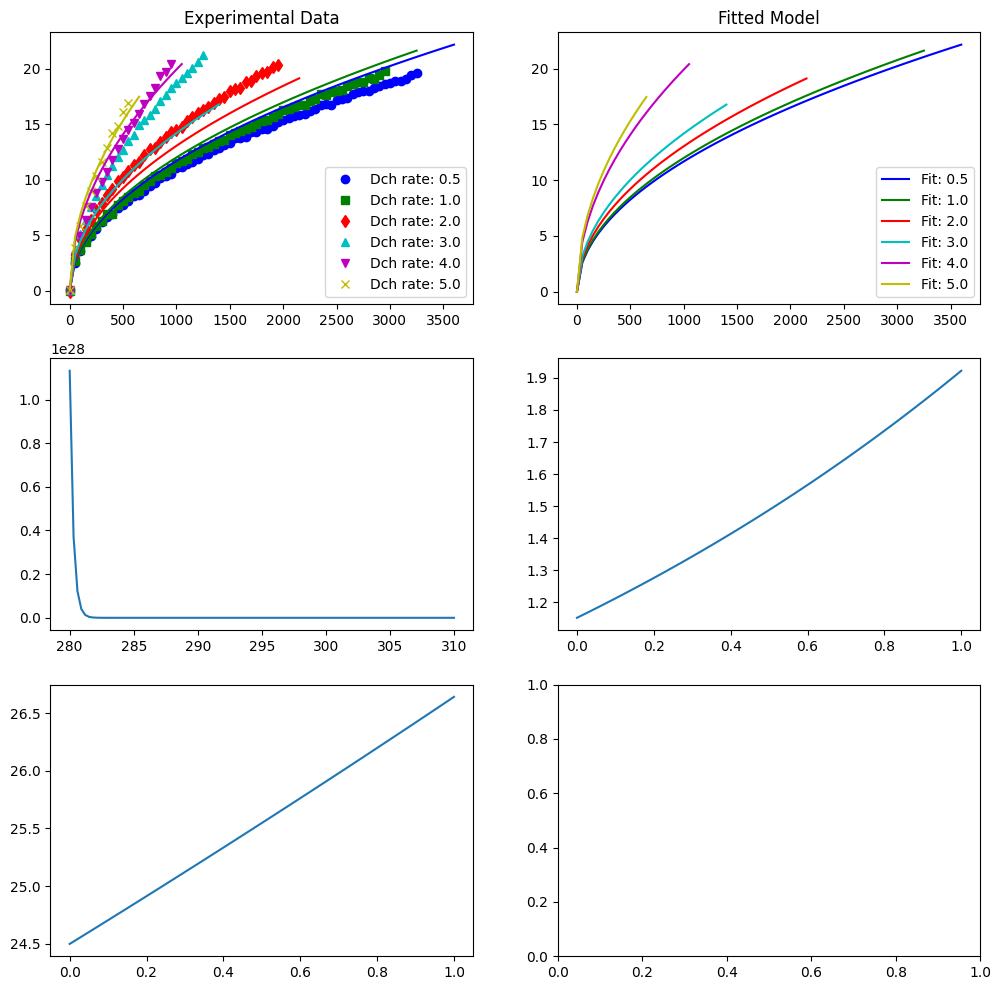

In [64]:



import numpy as np
import scipy.optimize as opt
from matplotlib import pyplot as plt

# -------------------------
# Data Loading and Generation
# -------------------------
exp_clist = np.array([0.37, 0.36, 0.46, 0.39, 0.27, 0.32])
exp_zlist = np.array([0.49, 0.50, 0.50, 0.56, 0.63, 0.63])

# Conditions used later for model evaluation
Templist  = np.array([298, 298, 298, 298, 298, 298])
Cratelist = np.array([0.53, 0.5, 0.5, 0.5, 1.0, 1.0])
Dratelist = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 5.0])

# Maximum cycles for each dataset (order: dataset with fastest Q growth last)
exp_maxcyclelist = np.array([3300, 3000, 2000, 1300, 1000, 600])
rand_normal_std = 0.1
np.random.seed(42)

def ExpDataCreator(n, C, z):
    return C * np.power(n, z)

_stride = 50
loss_data = [
    np.column_stack(
        (cycles := np.arange(0, maxcycle, _stride),
         ExpDataCreator(cycles, C, z) + np.random.normal(0, rand_normal_std, size=len(cycles)))
    )
    for C, z, maxcycle in zip(exp_clist, exp_zlist, exp_maxcyclelist)
]

# -------------------------
# Model Definition
# -------------------------
_n = 0.5
_Ea = 10000
_R = 8.314
_T0 = 298.15

def Q1Temp(params, Temp):
    """Temperature-dependent component.
       params: [h, DT, a]"""
    h, DT, a = params
    return h + DT * np.power(1. - np.exp(a * (Temp - _T0)), 2.)

def Q1ChCrate(params, Crate):
    """Charge rate component.
       params: [AC, RhoC]"""
    A, Rho = params
    return A * np.exp(Crate / Rho)

def Q1DchCrate(params, Crate):
    """Discharge rate component.
       params: [AD, RhoD]"""
    A, Rho = params
    return A * np.exp(Crate / Rho)

def Q1loss(params, condition, cyc):
    """
    Combined model output.
    params: [h, DT, a, AC, RhoC, AD, RhoD, B0]
    condition: [Temp, ChCrate, DchCrate]
    cyc: cycle number(s)
    """
    T_params = params[0:3]
    Ch_params = params[3:5]
    Dch_params = params[5:7]
    B0 = params[-1]

    Temp, ChCrate, DchCrate = condition
    return (B0 * Q1Temp(T_params, Temp) * Q1ChCrate(Ch_params, ChCrate) *
            Q1DchCrate(Dch_params, DchCrate) * np.exp(-_Ea / (Temp * _R)) *
            np.power(cyc, _n))

# -------------------------
# Initial Guess and Condition Data
# -------------------------
# Parameter initial guess: [h, DT, a, AC, RhoC, AD, RhoD, B0]
T1_initial_guess = [1, 0.2, 0.07]    # for Q1Temp
C1_initial_guess = [1, 10]           # for Q1ChCrate
D1_initial_guess = [24, 30]          # for Q1DchCrate
B0_initial_guess = [5000.]           # scale factor

initial_guess = T1_initial_guess + C1_initial_guess + D1_initial_guess + B0_initial_guess

# Construct condition data: each row corresponds to one dataset's [Temp, ChCrate, DchCrate]
condition_data = np.column_stack((Templist, Cratelist, Dratelist))

# -------------------------
# Objective Function with Penalty for Constraint Violations
# -------------------------
def objective_function(params, loss_data, condition_data):
    total_loss = 0.0
    # Sum squared residuals over datasets
    for data, condition in zip(loss_data, condition_data):
        cycles = data[:, 0]
        Qloss_data = data[:, 1]
        model_output = Q1loss(params, condition, cycles)
        residual = Qloss_data - model_output
        total_loss += np.linalg.norm(residual)**2

    # Penalty: ensure Q1Temp, Q1ChCrate, Q1DchCrate > 0 for all conditions.
    penalty = 0.0
    for condition in condition_data:
        Temp, ChCrate, DchCrate = condition
        f_temp = Q1Temp(params[0:3], Temp)
        f_charge = Q1ChCrate(params[3:5], ChCrate)
        f_dch = Q1DchCrate(params[5:7], DchCrate)
        if f_temp <= 0:
            penalty += 1e10 * (abs(f_temp) + 1.0)
        if f_charge <= 0:
            penalty += 1e10 * (abs(f_charge) + 1.0)
        if f_dch <= 0:
            penalty += 1e10 * (abs(f_dch) + 1.0)
    return total_loss + penalty

# -------------------------
# Global Optimization using Basin Hopping (with Penalty)
# -------------------------
tol = 1e-6
minimizer_kwargs = {'method': 'L-BFGS-B', 'tol': tol, 'args': (loss_data, condition_data)}
result = opt.basinhopping(objective_function, initial_guess,
                          minimizer_kwargs=minimizer_kwargs, niter=200, disp=True)
params = result.x

print("\nOptimized Parameters:", params)


# -------------------------
# Plotting the Results
# -------------------------
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
markers = ['o', 's', 'd', '^', 'v', 'x']
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plot original experimental data on the left
for k, (Drate, data) in enumerate(zip(Dratelist, loss_data)):
    x_data, y_data = data[:, 0], data[:, 1]
    ax[0,0].plot(x_data, y_data, linestyle='', marker=markers[k],
               color=colors[k], label=f'Dch rate: {Drate}')
ax[0,0].legend()
ax[0,0].set_title("Experimental Data")

# Generate and plot the fitted model curves using the optimized parameters
fit_result = [
    np.column_stack(
        (cycles := np.arange(0, maxcycle + int(maxcycle*0.1), _stride),
         Q1loss(params, condition, cycles))
    )
    for condition, maxcycle in zip(condition_data, exp_maxcyclelist)
]

for k, fit in enumerate(fit_result):
    dx_data, dy_data = fit[:, 0], fit[:, 1]
    ax[0,0].plot(dx_data, dy_data, linestyle='-', color=colors[k],
               label=f'Fit: {Dratelist[k]}')
    ax[0,1].plot(dx_data, dy_data, linestyle='-', color=colors[k],
               label=f'Fit: {Dratelist[k]}')
ax[0,1].legend()
ax[0,1].set_title("Fitted Model")

temp     = np.column_stack((tx := np.linspace(280,310,100), Q1Temp(params[0:3],tx)))
ax[1,0].plot(temp[:,0],temp[:,1],linestyle='-')
ch_crate = np.column_stack((cr := np.linspace(0,1,100), Q1ChCrate(params[3:5],cr)))
ax[1,1].plot(ch_crate[:,0],ch_crate[:,1],linestyle='-')
dch_crate= np.column_stack((cr := np.linspace(0,1,100), Q1DchCrate(params[5:7],cr)))
ax[2,0].plot(dch_crate[:,0],dch_crate[:,1],linestyle='-')


plt.show()
